In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data 
# (https://www.kaggle.com/mlg-ulb/creditcardfraud)
df = pd.read_csv('creditcard.csv')
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))
df.head()

Dataset shape: (284807, 31)

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


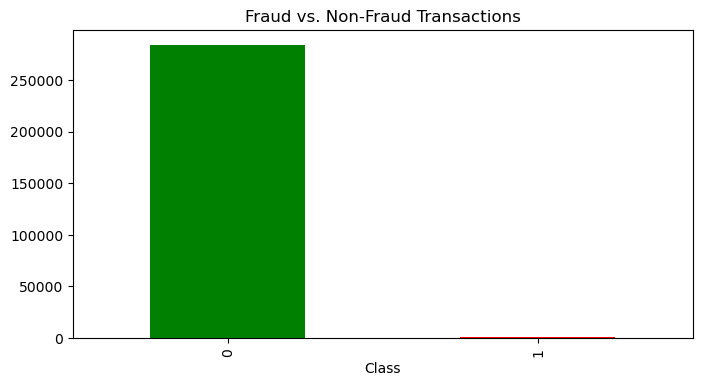

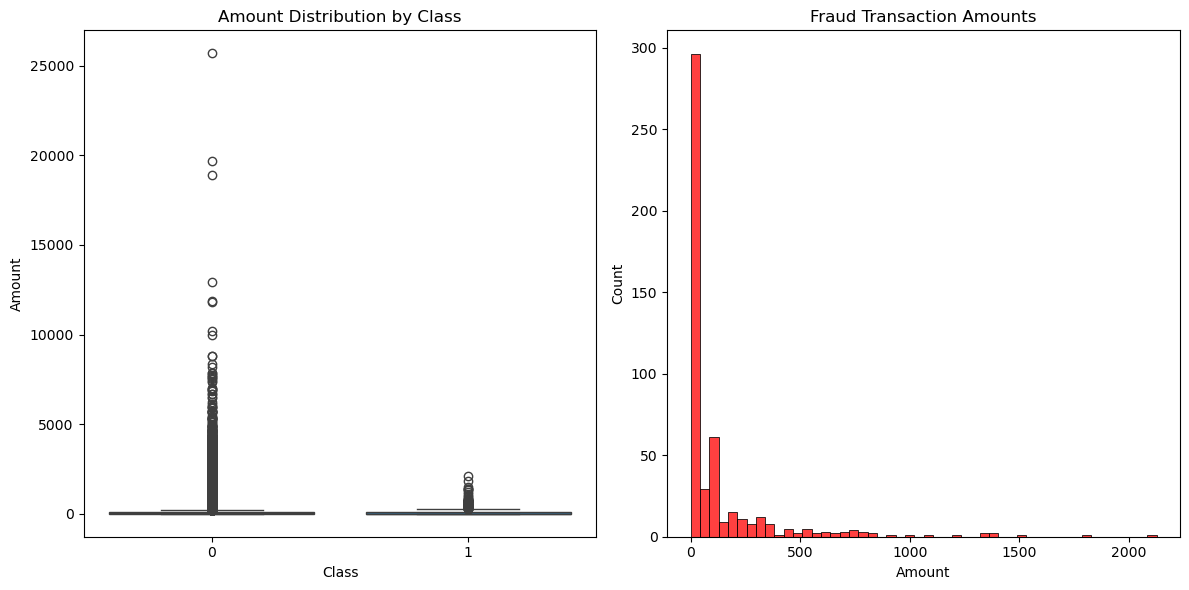

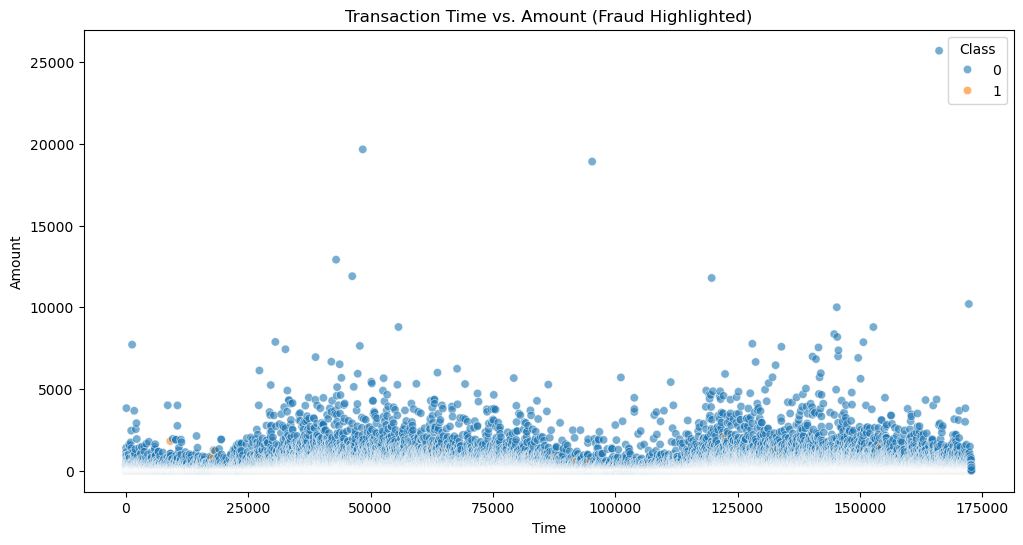


Top correlated features with fraud:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


In [3]:
# EDA
# Class distribution
plt.figure(figsize=(8, 4))
df['Class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

# Transaction amount distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount Distribution by Class')

plt.subplot(1, 2, 2)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red')
plt.title('Fraud Transaction Amounts')
plt.tight_layout()
plt.show()

# Time vs Fraud
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df, alpha=0.6)
plt.title('Transaction Time vs. Amount (Fraud Highlighted)')
plt.show()

# Correlation with fraud
corr = df.corr()['Class'].abs().sort_values(ascending=False)[1:11]
print("\nTop correlated features with fraud:")
print(corr)

In [4]:
# Preprocessing
# Separate features and target
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Train test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Scale only the Amount column
preprocessor = ColumnTransformer([
    ('scale_amount', StandardScaler(), ['Amount'])
], remainder='passthrough')

In [5]:
# Model Definitions
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
    'XGBoost': XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        eval_metric='logloss',
        random_state=42
    )
}

In [6]:
# Train and evaluate each model
results = []
for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    print(f"{'='*40}")
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    # Metrics
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
    
    # Store results
    results.append({
        'Model': name,
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

# Compare models
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Comparison:")
print(results_df.sort_values('ROC AUC', ascending=False))


Training LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC AUC: 0.971

Training RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.958

Training XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.86      0.88        98

    accuracy                           1.00     56962
   macro avg       0.95     

In [7]:
# Final model
best_model_name = results_df['ROC AUC'].idxmax()
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} (ROC AUC = {results_df.loc[best_model_name, 'ROC AUC']:.3f})")

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])
final_pipeline.fit(X_train, y_train)


Best model: LogisticRegression (ROC AUC = 0.971)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_amount',
                                                  StandardScaler(),
                                                  ['Amount'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

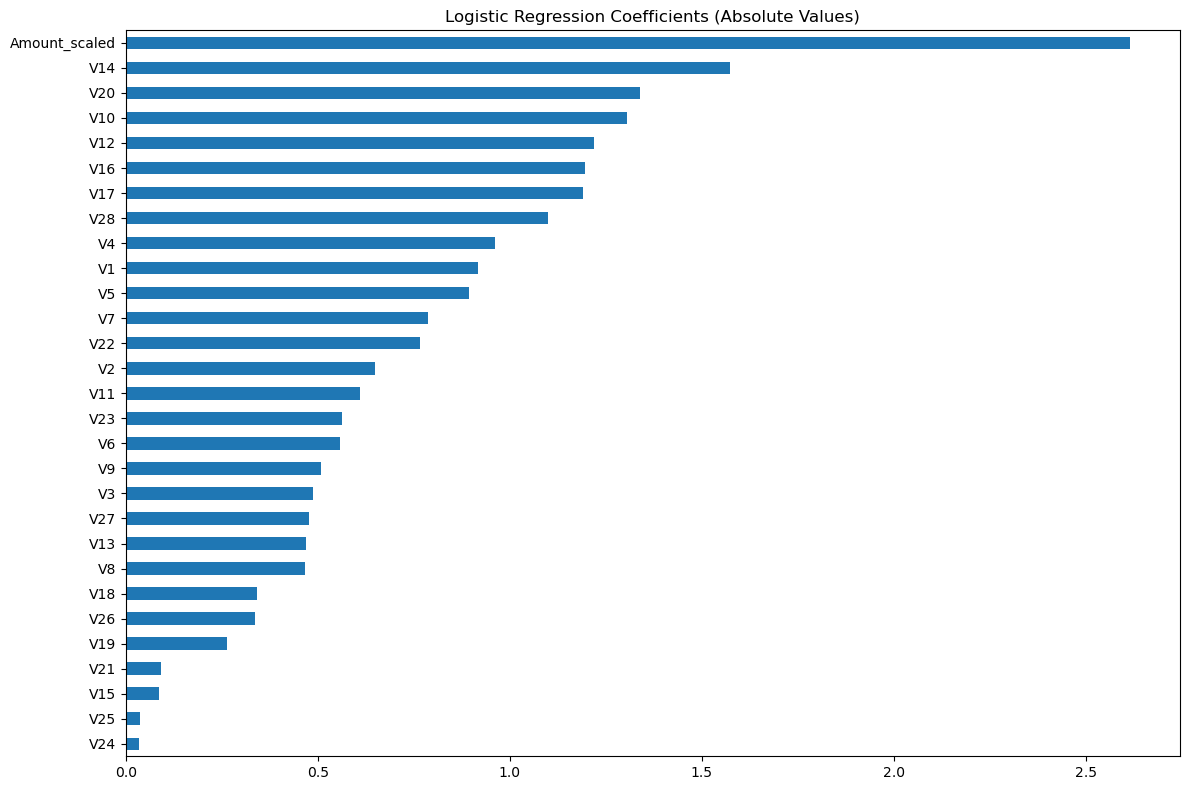

In [8]:
# Feature Importance
# Get feature names
feature_names = ['Amount_scaled'] + [col for col in X.columns if col != 'Amount']

plt.figure(figsize=(12, 8))

if hasattr(best_model, 'coef_'):  # For LogisticRegression
    importance = pd.Series(np.abs(best_model.coef_[0]), index=feature_names)
    plt.title('Logistic Regression Coefficients (Absolute Values)')
elif hasattr(best_model, 'feature_importances_'):  # For XGBoost/RandomForest
    importance = pd.Series(best_model.feature_importances_, index=feature_names)
    plt.title('Feature Importance')
else:
    raise ValueError("Model type not supported for importance visualization")

if importance is not None:
    importance.sort_values().plot(kind='barh')
    plt.tight_layout()
    plt.show()

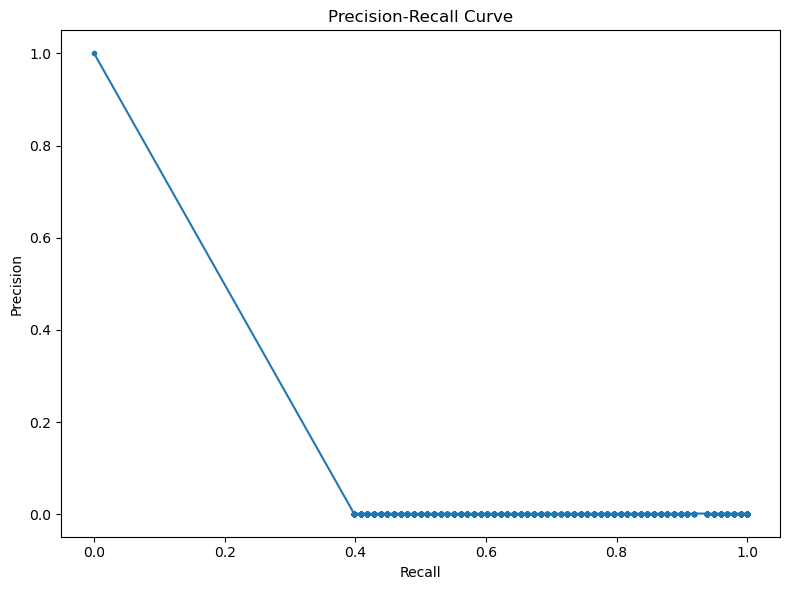

In [9]:
# Precision Recall Curve
y_proba = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

In [10]:
# Cross Validation
cv_scores = cross_val_score(final_pipeline, X, y, cv=5, scoring='roc_auc')
print("\nCross-Validated ROC AUC Scores:", cv_scores)
print("Average ROC AUC:", np.mean(cv_scores))


Cross Validated ROC AUC Scores: [0.95782775 0.9754439  0.94239969 0.97653167 0.98143784]
Average ROC AUC: 0.9667281717115779
